In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# необходимые модули
import torch
import random
import numpy as np
import pandas as pd
import json
import base64
import os
import pylab
import torchvision
import shutil
import matplotlib.pyplot as plt
from torchvision import transforms, models
from tqdm import tqdm
import cv2
import pylab
from google.colab.patches import cv2_imshow
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
train_dir = '/content/drive/MyDrive/hac2021/train'
test_dir='/content/drive/MyDrive/hac2021/test'

In [ ]:
!rm -rf 'train_png'
!rm -rf 'val_png'
os.makedirs('/content/train_png')
os.makedirs('/content/val_png')
os.makedirs('/content/train_png/image')
os.makedirs('/content/train_png/mask')
os.makedirs('/content/val_png/image')
os.makedirs('/content/val_png/mask')

In [ ]:
# number_train_photo=int(len(os.listdir(train_dir))/2)
# FILE_FILTER=['.png','.json']
# for index in range(1,number_train_photo+1): 
#     if index<10:
#       number="00{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index<100 and index>=10:
#       number="0{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index>=100:
#       number='{index}'.format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)

#     with open(current+FILE_FILTER[1], 'r', encoding='utf-8') as fh: #открываем файл на чтение
#       data = json.load(fh) #загружаем из файл а данные в словарь data
#       class_photo=data['shapes'][0]['label']
#       train_path='/content/train/'+'{path}/'.format(path=class_photo)
#       train_png_path='/content/train_png'
#       train_json_path='/content/train_json'
#       shutil.copy(train_dir+number+FILE_FILTER[0], train_png_path)
#       shutil.copy(train_dir+number+FILE_FILTER[1], train_json_path)

In [ ]:
# gpuid=0
# if(torch.cuda.is_available()):
#     print(torch.cuda.get_device_properties(gpuid))
#     torch.cuda.set_device(gpuid)
#     device = torch.device(f'cuda:{gpuid}')
# else:
#     device = torch.device(f'cpu')

In [ ]:
val_part=6
number_train_photo=int(len(os.listdir(train_dir))/2)
iter=0
for image in sorted(os.listdir(train_dir+'/image')):
  if iter%val_part!=0:
    shutil.copy(train_dir+'/image/'+image,'/content/train_png/image')
  else:
    shutil.copy(train_dir+'/image/'+image,'/content/val_png/image')   
  iter+=1
iter=0
for mask in sorted(os.listdir(train_dir+'/mask')):
  if iter%val_part!=0:
    shutil.copy(train_dir+'/mask/'+mask,'/content/train_png/mask')
  else:
    shutil.copy(train_dir+'/mask/'+mask,'/content/val_png/mask')  
  iter+=1


In [ ]:
# val_part=20
# number_train_photo=int(len(os.listdir(train_dir))/2)
# FILE_FILTER=['.png']
# for index in range(1,number_train_photo+1): 
#     if index<10:
#       number="00{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index<100 and index>=10:
#       number="0{index}".format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)
#     elif index>=100:
#       number='{index}'.format(index=index)
#       current='/content/drive/My Drive/dataset_its/train/'+number
#       print(current)

#     if index%val_part!=0:
#       train_png_path='/content/train_png'
#       train_json_path='/content/train_json'
#       shutil.copy(train_dir+number+FILE_FILTER[0], train_png_path)
#       shutil.copy(train_dir+number+FILE_FILTER[1], train_json_path)
#     else:
#       val_png_path='/content/val_png'
#       val_json_path='/content/val_json'
#       shutil.copy(train_dir+number+FILE_FILTER[0], val_png_path)
#       shutil.copy(train_dir+number+FILE_FILTER[1], val_json_path)



In [ ]:
# train_json_path='/content/train_json/'
# val_json_path='/content/val_json/'
# json_path=[train_json_path, val_json_path]
# train_mask=[]
# val_mask=[]
# for path in json_path:
#   for filename in sorted(os.listdir(path)):
#       with open(os.path.join(path, filename), 'r') as f:
#         layout = json.load(f)
#       h, w = layout['imageHeight'], layout['imageWidth']
#       true_mask = np.zeros((h, w), np.uint8)
#       label = layout['shapes'][0]['label']
#       for shape in layout['shapes']:
#         polygon = np.array([point[::-1] for point in shape['points']])
#         cv2.fillPoly(true_mask, [polygon[:, [1, 0]]], 255)
#       # cv2_imshow(true_mask)
#       if path==train_json_path:
#         train_mask.append(true_mask)
#       else:
#         val_mask.append(true_mask)
# train_mask=np.array(train_mask)
# val_mask=np.array(val_mask)

In [ ]:
dataname="defect_area"
ignore_index = -100 
gpuid=0

# --- unet params

n_classes= 1    #number of classes in the data mask that we'll aim to predict
in_channels= 3  #input channel of the data, RGB = 3
padding= True   #should levels be padded
depth= 2      #depth of the network 
wf= 4           #wf (int): number of filters in the first layer is 2**wf, was 6
up_mode= 'upsample' #should we simply upsample the mask, or should we try and learn an interpolation 
batch_norm = True #should we use batch normalization between the layers

# --- training params
batch_size=8
patch_size=500
num_epochs = 50
edge_weight = 1.1 
phases = ["train","val"] #how many phases did we create databases for?
validation_phases= ["val"] #when should we do valiation? note that validation is time consuming, so as opposed to doing for both training and validation, we do it only for vlaidation at the end of the epoch

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models


from unet import UNet #code borrowed from https://github.com/jvanvugt/pytorch-unet

import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import cv2

import numpy as np
import sys, glob

# from tensorboardX import SummaryWriter

import scipy.ndimage 

import time
import math
import tables

import random

from sklearn.metrics import confusion_matrix



In [ ]:
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15109MB, multi_processor_count=40)


In [ ]:
train_png_path='/content/train_png/image/'
val_png_path='/content/val_png/image/'
png_path=[train_png_path, val_png_path]
train_set=[]
val_set=[]
iter=0
for path in png_path:
  for file in sorted(os.listdir(path)):
    iter+=1
    image = cv2.imread(path+'{file}'.format(file=file))
    # image_rgb = image.astype(np.uint8)
    if path==train_png_path:
      train_set.append(image) 
    else:
      val_set.append(image)
train_set=np.array(train_set)
val_set=np.array(val_set)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
train_png_path='/content/train_png/mask/'
val_png_path='/content/val_png/mask/'
png_path=[train_png_path, val_png_path]
train_mask=[]
val_mask=[]
iter=0
for path in png_path:
  for file in sorted(os.listdir(path)):
    iter+=1
    image = cv2.imread(path+'{file}'.format(file=file),0)
    # image_rgb = image.astype(np.uint8)
    if path==train_png_path:
      train_mask.append(image) 
    else:
      val_mask.append(image)
train_mask=np.array(train_mask)
val_mask=np.array(val_mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
print(len(train_set))
print(len(train_mask))

55
55


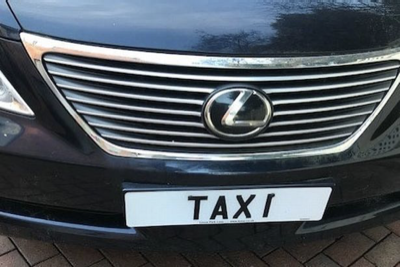

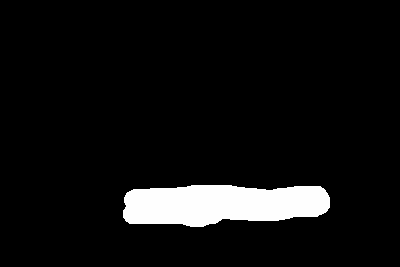

In [ ]:
cv2_imshow(train_set[10])
cv2_imshow(train_mask[10])

In [ ]:
print(train_set.shape)
print(train_mask.shape)
print(val_set.shape)
print(val_mask.shape)

(55,)
(55,)
(11,)
(12,)


In [ ]:

class SimDataset(Dataset):
  def __init__(self, input_image, input_mask=None, transform_image=None, transform_mask=None):
    self.transform_image = transform_image
    self.transform_mask=transform_mask
    self.input_images = input_image
    self.target_masks = input_mask


  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    if self.target_masks is not None:
      mask = self.target_masks[idx]
    if self.transform_image is not None:
      image = self.transform_image(image)
    if self.transform_mask is not None:
      mask=self.transform_mask(mask)
    if self.target_masks is not None:
      return [image, mask]
    else:  
      return image

# use the same transformations for train/val in this example
trans = transforms.Compose([
  # transforms.ToPILImage(),
  # transforms.Resize(800),
  # transforms.ToTensor()
  # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
img_transform = transforms.Compose([
                                    


     transforms.ToPILImage(),

    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    # transforms.RandomResizedCrop(size=patch_size),
    # transforms.RandomRotation(180),
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
    # transforms.RandomGrayscale(),
    transforms.Resize((500,500)),
    transforms.ToTensor()
    ])

mask_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
    # transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
    # transforms.RandomRotation(180),
    transforms.Resize((500,500)),
    transforms.ToTensor()
    ])
train_dataset = SimDataset(train_set,train_mask, transform_image = img_transform, transform_mask = mask_transform)
val_dataset = SimDataset(val_set,val_mask, transform_image = img_transform, transform_mask=mask_transform)

# batch_size = 25
image_datasets = {
  'train': train_set, 'val': val_set
}

dataloaders = {
  'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
}


In [ ]:
# img_transform = transforms.Compose([
#      transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
#     transforms.RandomResizedCrop(size=patch_size),
#     transforms.RandomRotation(180),
#     transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=.5),
#     transforms.RandomGrayscale(),
#     transforms.ToTensor()
#     ])


# mask_transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomVerticalFlip(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomCrop(size=(patch_size,patch_size),pad_if_needed=True), #these need to be in a reproducible order, first affine transforms and then color
#     transforms.RandomResizedCrop(size=patch_size,interpolation=PIL.Image.NEAREST),
#     transforms.RandomRotation(180),
#     ])


In [ ]:
# import torch
# import torch.optim as optim
# from torch.optim import lr_scheduler
# import time
# import copy

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

# num_class = 6
# model = ResNetUNet(num_class).to(device)

# # freeze backbone layers
# #for l in model.base_layers:
# #    for param in l.parameters():
# #        param.requires_grad = False

# optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

# model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

In [ ]:

model = UNet(n_classes=n_classes, in_channels=in_channels, padding=padding,depth=depth,wf=wf, up_mode=up_mode, batch_norm=batch_norm).to(device)
print(f"total params: \t{sum([np.prod(p.size()) for p in model.parameters()])}")

total params: 	24401


In [ ]:
import torch
import torch.nn as nn

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

In [ ]:
from collections import defaultdict
import torch.nn.functional as F

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

In [ ]:
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=300)

Epoch 0/299
----------
LR 0.0001


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train: bce: 0.654502, dice: 0.944084, loss: 0.799293
val: bce: 0.515880, dice: 0.978602, loss: 0.747241
saving best model
0m 2s
Epoch 1/299
----------
LR 0.0001
train: bce: 0.651162, dice: 0.943796, loss: 0.797479
val: bce: 0.537573, dice: 0.978647, loss: 0.758110
0m 2s
Epoch 2/299
----------
LR 0.0001
train: bce: 0.647958, dice: 0.942853, loss: 0.795406
val: bce: 0.566969, dice: 0.978331, loss: 0.772650
0m 2s
Epoch 3/299
----------
LR 0.0001
train: bce: 0.645801, dice: 0.942225, loss: 0.794013
val: bce: 0.588889, dice: 0.977892, loss: 0.783390
0m 2s
Epoch 4/299
----------
LR 0.0001
train: bce: 0.643033, dice: 0.941628, loss: 0.792330
val: bce: 0.612977, dice: 0.977517, loss: 0.795247
0m 2s
Epoch 5/299
----------
LR 0.0001
train: bce: 0.640934, dice: 0.941285, loss: 0.791110
val: bce: 0.631926, dice: 0.976917, loss: 0.804422
0m 2s
Epoch 6/299
----------
LR 0.0001
train: bce: 0.639748, dice: 0.940865, loss: 0.790307
val: bce: 0.643405, dice: 0.976234, loss: 0.809819
0m 2s
Epoch 7/299
--

KeyboardInterrupt: ignored

In [ ]:
torch.save(model, '/content/segmentation_model.txt')

In [ ]:
test_png_path='/content/val_png/image/'
test_set=[]
iter=0
for file in sorted(os.listdir(test_png_path)):

    iter+=1
    image = cv2.imread(test_png_path+'{file}'.format(file=file))
    # image_rgb = image.astype(np.uint8)
    test_set.append(image)
test_set=np.array(test_set)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
import math

model.eval()   # Set model to the evaluation mode
# Create another simulation dataset for test
test_dataset = SimDataset(input_image=test_set,transform_image = img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_dataset = SimDataset(input_image=val_set,transform_image = img_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp

[[[0.5921569  0.5529412  0.45490196 ... 0.28235295 0.26666668 0.25490198]
  [0.56078434 0.53333336 0.50980395 ... 0.28235295 0.27058825 0.24705882]
  [0.5254902  0.5647059  0.53333336 ... 0.28627452 0.27450982 0.23921569]
  ...
  [0.1882353  0.21568628 0.22352941 ... 0.32156864 0.32156864 0.32156864]
  [0.17254902 0.2        0.22352941 ... 0.32156864 0.32156864 0.32156864]
  [0.16470589 0.1882353  0.21960784 ... 0.32156864 0.32156864 0.32156864]]

 [[0.43529412 0.42745098 0.3764706  ... 0.27450982 0.26666668 0.2509804 ]
  [0.36862746 0.38431373 0.42352942 ... 0.2784314  0.27058825 0.24705882]
  [0.28627452 0.38039216 0.42745098 ... 0.2784314  0.27450982 0.23529412]
  ...
  [0.19215687 0.21960784 0.22745098 ... 0.3019608  0.3019608  0.3019608 ]
  [0.1764706  0.2        0.22352941 ... 0.3019608  0.3019608  0.3019608 ]
  [0.16862746 0.19215687 0.22352941 ... 0.3019608  0.3019608  0.3019608 ]]

 [[0.29803923 0.30980393 0.29411766 ... 0.19607843 0.1764706  0.16862746]
  [0.21960784 0.254901

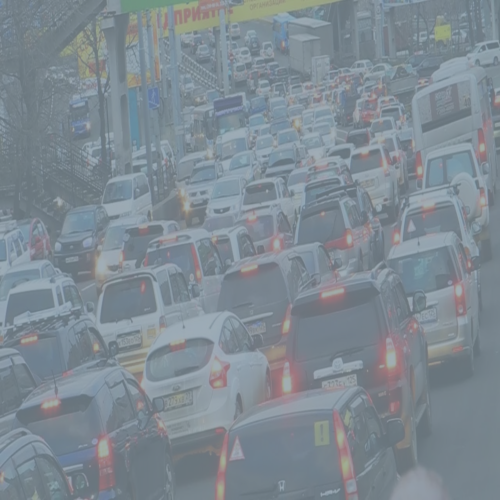

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


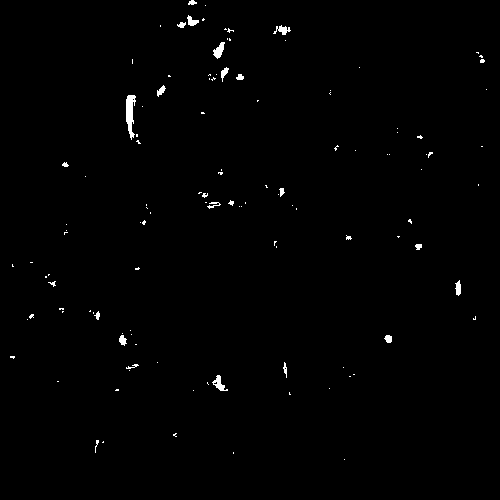

[[[0.9647059  0.9490196  0.9490196  ... 0.9529412  0.9529412  0.95686275]
  [0.9607843  0.9490196  0.9490196  ... 0.9529412  0.9529412  0.95686275]
  [0.9490196  0.94509804 0.9490196  ... 0.9529412  0.9529412  0.95686275]
  ...
  [0.2        0.17254902 0.19215687 ... 0.5764706  0.5764706  0.6117647 ]
  [0.1764706  0.1882353  0.18039216 ... 0.5803922  0.5882353  0.60784316]
  [0.16470589 0.19607843 0.1764706  ... 0.5803922  0.59607846 0.6039216 ]]

 [[0.92941177 0.93333334 0.93333334 ... 0.95686275 0.95686275 0.9607843 ]
  [0.92941177 0.93333334 0.93333334 ... 0.95686275 0.95686275 0.9607843 ]
  [0.93333334 0.93333334 0.9372549  ... 0.95686275 0.95686275 0.9607843 ]
  ...
  [0.41568628 0.40392157 0.43137255 ... 0.7058824  0.7058824  0.72156864]
  [0.3882353  0.39215687 0.41568628 ... 0.7137255  0.7254902  0.7254902 ]
  [0.3764706  0.3882353  0.40784314 ... 0.7176471  0.73333335 0.7254902 ]]

 [[0.9137255  0.90588236 0.9098039  ... 0.9411765  0.9411765  0.94509804]
  [0.9098039  0.905882

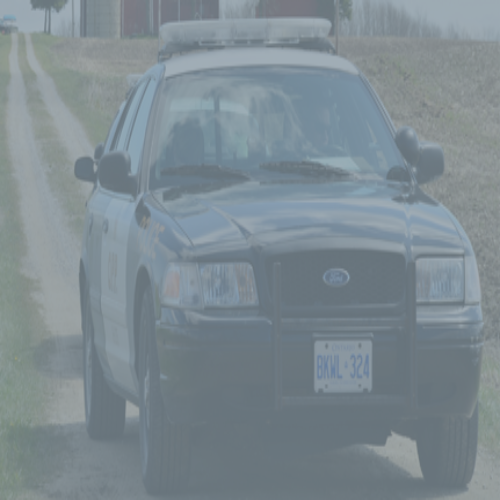

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


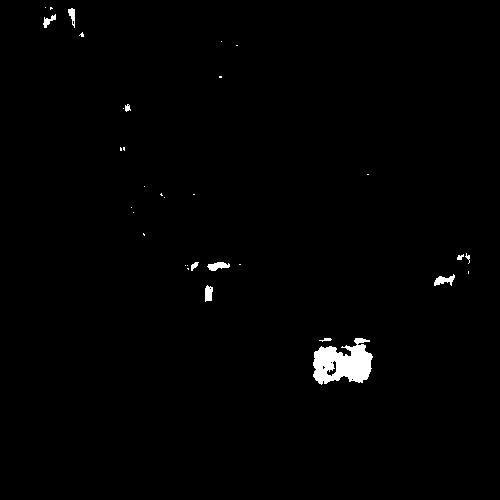

[[[0.01960784 0.02745098 0.03137255 ... 0.         0.         0.        ]
  [0.01960784 0.02745098 0.03137255 ... 0.         0.         0.        ]
  [0.01568628 0.02352941 0.02745098 ... 0.         0.         0.        ]
  ...
  [0.01176471 0.01176471 0.01176471 ... 0.07058824 0.08235294 0.07843138]
  [0.01176471 0.01176471 0.01176471 ... 0.05882353 0.06666667 0.0627451 ]
  [0.01176471 0.01176471 0.01176471 ... 0.05490196 0.05882353 0.05490196]]

 [[0.01960784 0.02745098 0.03137255 ... 0.         0.         0.        ]
  [0.01960784 0.02745098 0.03137255 ... 0.         0.         0.        ]
  [0.01568628 0.02352941 0.02745098 ... 0.         0.         0.        ]
  ...
  [0.00392157 0.00392157 0.00392157 ... 0.07843138 0.09019608 0.08627451]
  [0.00392157 0.00392157 0.00392157 ... 0.06666667 0.07450981 0.07058824]
  [0.00392157 0.00392157 0.00392157 ... 0.0627451  0.06666667 0.0627451 ]]

 [[0.04313726 0.05098039 0.05882353 ... 0.         0.         0.        ]
  [0.04313726 0.050980

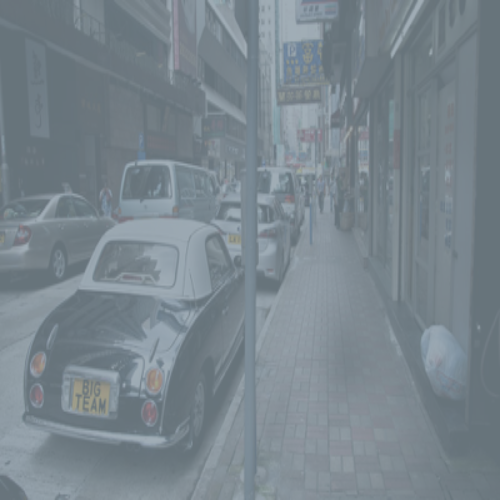

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


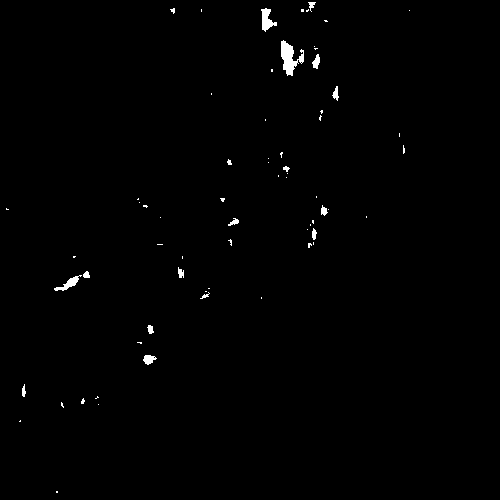

[[[0.77254903 0.76862746 0.76862746 ... 0.75686276 0.7490196  0.7254902 ]
  [0.7647059  0.7607843  0.75686276 ... 0.75686276 0.7490196  0.7294118 ]
  [0.75686276 0.74509805 0.7372549  ... 0.7607843  0.7490196  0.73333335]
  ...
  [0.90588236 0.90588236 0.90588236 ... 0.34901962 0.34901962 0.3529412 ]
  [0.9019608  0.90588236 0.90588236 ... 0.3529412  0.34901962 0.3372549 ]
  [0.9019608  0.90588236 0.90588236 ... 0.3529412  0.34901962 0.32941177]]

 [[0.79607844 0.7921569  0.7921569  ... 0.75686276 0.7490196  0.7254902 ]
  [0.7921569  0.78431374 0.78431374 ... 0.75686276 0.7490196  0.7294118 ]
  [0.78431374 0.77254903 0.7647059  ... 0.7607843  0.7490196  0.73333335]
  ...
  [0.9411765  0.9411765  0.9411765  ... 0.4117647  0.4117647  0.41568628]
  [0.9372549  0.9411765  0.9411765  ... 0.41568628 0.4117647  0.4       ]
  [0.9372549  0.9411765  0.9411765  ... 0.41568628 0.4117647  0.39215687]]

 [[0.81960785 0.8156863  0.8156863  ... 0.75686276 0.7490196  0.7254902 ]
  [0.8156863  0.807843

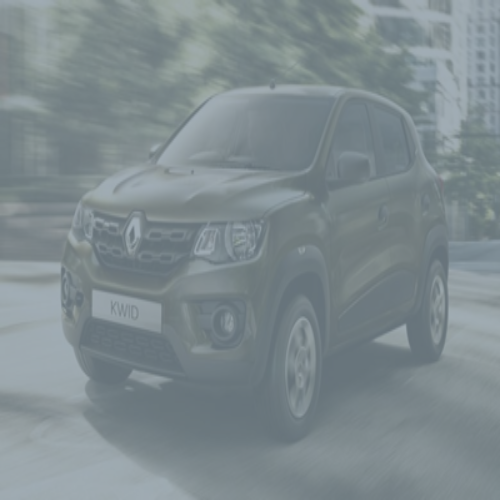

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


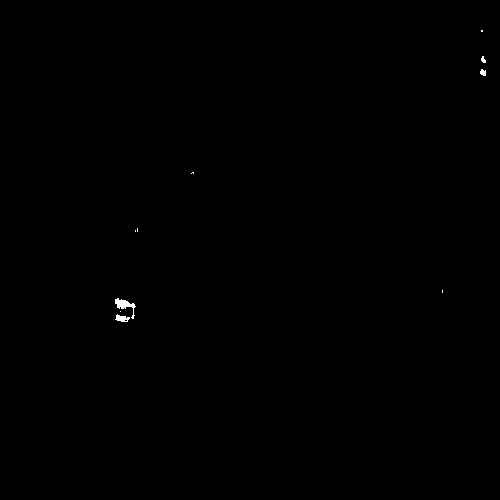

[[[0.84313726 0.84313726 0.84313726 ... 0.972549   0.972549   0.96862745]
  [0.84313726 0.84313726 0.84313726 ... 0.972549   0.972549   0.96862745]
  [0.84313726 0.84313726 0.84313726 ... 0.96862745 0.96862745 0.96862745]
  ...
  [0.32156864 0.31764707 0.33333334 ... 0.62352943 0.62352943 0.62352943]
  [0.32941177 0.3372549  0.3529412  ... 0.61960787 0.61960787 0.6156863 ]
  [0.33333334 0.34901962 0.36078432 ... 0.61960787 0.6156863  0.6117647 ]]

 [[0.8117647  0.8117647  0.8117647  ... 0.9764706  0.9764706  0.9764706 ]
  [0.8117647  0.8117647  0.8117647  ... 0.9764706  0.9764706  0.9764706 ]
  [0.8117647  0.8117647  0.8117647  ... 0.9764706  0.9764706  0.9764706 ]
  ...
  [0.44705883 0.44705883 0.47058824 ... 0.7019608  0.7019608  0.7019608 ]
  [0.46666667 0.4745098  0.49019608 ... 0.69803923 0.69803923 0.69803923]
  [0.4745098  0.49019608 0.5019608  ... 0.69803923 0.69803923 0.69411767]]

 [[0.7490196  0.7490196  0.7490196  ... 0.9607843  0.9607843  0.95686275]
  [0.7490196  0.749019

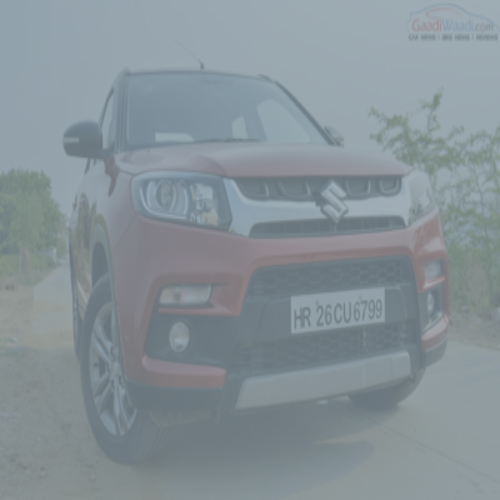

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


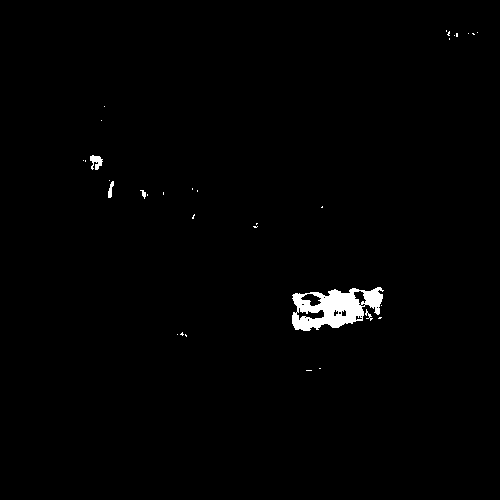

[[[0.89411765 0.89411765 0.8862745  ... 1.         1.         1.        ]
  [0.89411765 0.89411765 0.8862745  ... 1.         1.         1.        ]
  [0.89411765 0.89411765 0.8862745  ... 1.         1.         1.        ]
  ...
  [0.8117647  0.8117647  0.8117647  ... 0.7019608  0.7019608  0.69803923]
  [0.8117647  0.8117647  0.8117647  ... 0.7058824  0.70980394 0.7058824 ]
  [0.8117647  0.8117647  0.8117647  ... 0.7058824  0.70980394 0.7058824 ]]

 [[1.         0.99607843 0.9882353  ... 1.         1.         1.        ]
  [1.         0.99607843 0.9882353  ... 1.         1.         1.        ]
  [1.         0.99607843 0.9882353  ... 1.         1.         1.        ]
  ...
  [0.76862746 0.76862746 0.76862746 ... 0.7411765  0.7411765  0.73333335]
  [0.76862746 0.76862746 0.76862746 ... 0.7411765  0.74509805 0.7411765 ]
  [0.76862746 0.76862746 0.76862746 ... 0.7411765  0.74509805 0.7411765 ]]

 [[1.         1.         0.99215686 ... 1.         1.         1.        ]
  [1.         1.      

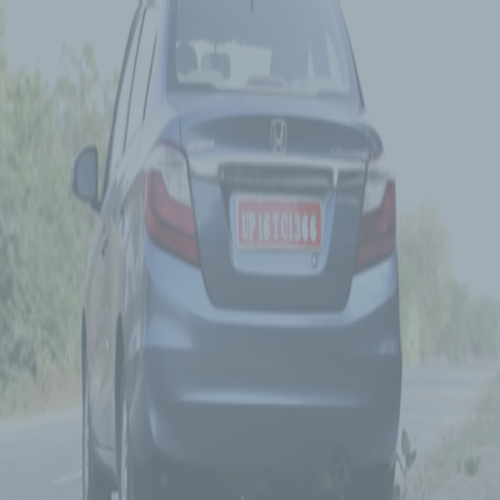

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


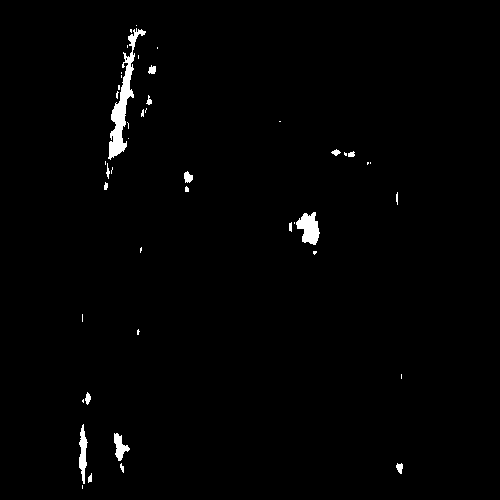

[[[0.9490196  0.9490196  0.9490196  ... 0.92156863 0.9137255  0.9098039 ]
  [0.9529412  0.9529412  0.95686275 ... 0.9254902  0.91764706 0.9098039 ]
  [0.95686275 0.9607843  0.9647059  ... 0.92941177 0.92156863 0.9098039 ]
  ...
  [0.13725491 0.19215687 0.24705882 ... 0.10980392 0.10196079 0.09411765]
  [0.11764706 0.14117648 0.16862746 ... 0.10588235 0.10588235 0.09803922]
  [0.10196079 0.10980392 0.11764706 ... 0.10588235 0.10588235 0.10196079]]

 [[0.9372549  0.9372549  0.93333334 ... 0.88235295 0.8784314  0.8745098 ]
  [0.9372549  0.9372549  0.9372549  ... 0.88235295 0.8784314  0.8745098 ]
  [0.93333334 0.9372549  0.9411765  ... 0.8862745  0.88235295 0.8745098 ]
  ...
  [0.14117648 0.19215687 0.24313726 ... 0.11764706 0.10980392 0.09803922]
  [0.11764706 0.14117648 0.16862746 ... 0.11372549 0.10980392 0.10196079]
  [0.10196079 0.10980392 0.11764706 ... 0.10980392 0.10980392 0.10196079]]

 [[0.9019608  0.9019608  0.8980392  ... 0.8745098  0.87058824 0.8666667 ]
  [0.9019608  0.905882

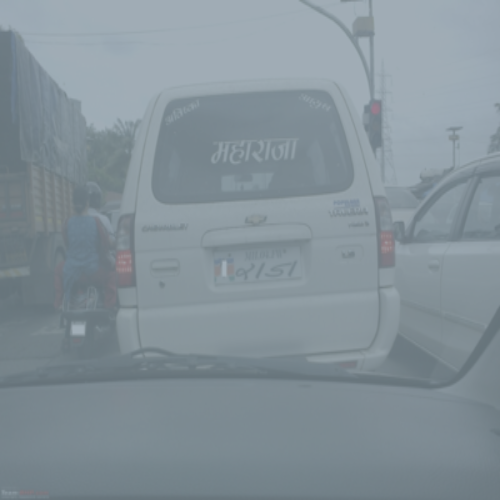

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


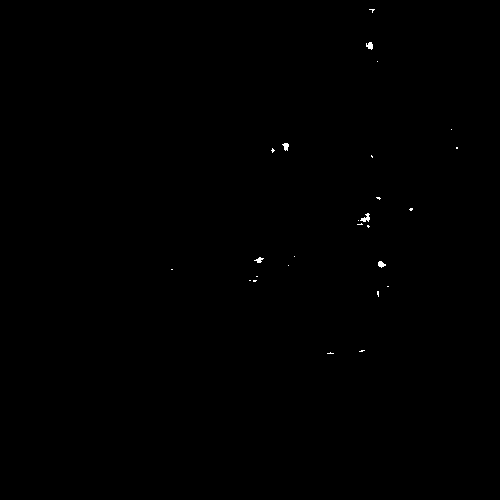

[[[0.9372549  0.94509804 0.92156863 ... 0.99215686 0.972549   0.972549  ]
  [0.9372549  0.9490196  0.93333334 ... 0.93333334 0.84705883 0.7647059 ]
  [0.91764706 0.93333334 0.91764706 ... 0.6392157  0.5254902  0.47843137]
  ...
  [0.14901961 0.00784314 0.00392157 ... 0.3372549  0.33333334 0.29803923]
  [0.14117648 0.00392157 0.00784314 ... 0.3137255  0.3254902  0.3019608 ]
  [0.13725491 0.00392157 0.01176471 ... 0.31764707 0.32156864 0.30980393]]

 [[0.9098039  0.91764706 0.8862745  ... 0.99215686 0.99607843 0.99215686]
  [0.9098039  0.92156863 0.89411765 ... 0.91764706 0.85490197 0.76862746]
  [0.8901961  0.9019608  0.8784314  ... 0.6509804  0.54901963 0.49019608]
  ...
  [0.14901961 0.00784314 0.00392157 ... 0.33333334 0.32941177 0.29803923]
  [0.14117648 0.00392157 0.00784314 ... 0.30588236 0.31764707 0.29803923]
  [0.13725491 0.00392157 0.01176471 ... 0.30980393 0.3137255  0.30588236]]

 [[0.8980392  0.9098039  0.8862745  ... 0.99215686 0.99607843 0.99215686]
  [0.8980392  0.913725

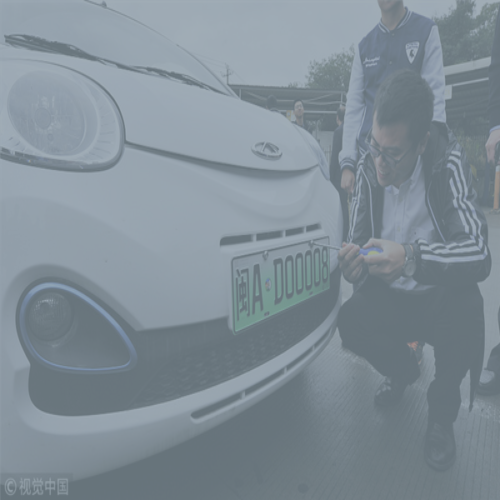

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


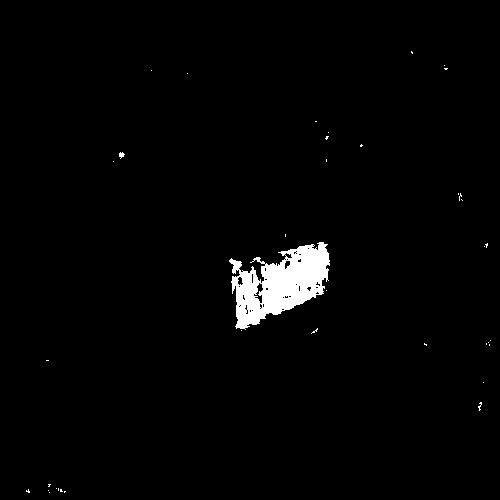

[[[0.04313726 0.0627451  0.1764706  ... 0.6        0.59607846 0.6       ]
  [0.07058824 0.05882353 0.16078432 ... 0.6        0.6        0.59607846]
  [0.14117648 0.0627451  0.13725491 ... 0.6        0.6        0.6       ]
  ...
  [0.09803922 0.10980392 0.06666667 ... 0.28235295 0.27450982 0.25882354]
  [0.07450981 0.09019608 0.12156863 ... 0.2784314  0.23529412 0.21960784]
  [0.05490196 0.09803922 0.13333334 ... 0.27058825 0.24313726 0.24705882]]

 [[0.05098039 0.07058824 0.1882353  ... 0.59607846 0.5921569  0.59607846]
  [0.07843138 0.0627451  0.17254902 ... 0.59607846 0.59607846 0.5921569 ]
  [0.14901961 0.06666667 0.14901961 ... 0.59607846 0.59607846 0.59607846]
  ...
  [0.10980392 0.12156863 0.07843138 ... 0.27450982 0.27058825 0.2509804 ]
  [0.08235294 0.09803922 0.14117648 ... 0.27058825 0.22745098 0.21568628]
  [0.0627451  0.10588235 0.15294118 ... 0.26666668 0.23921569 0.23921569]]

 [[0.05098039 0.07058824 0.18039216 ... 0.5803922  0.5764706  0.5803922 ]
  [0.07843138 0.066666

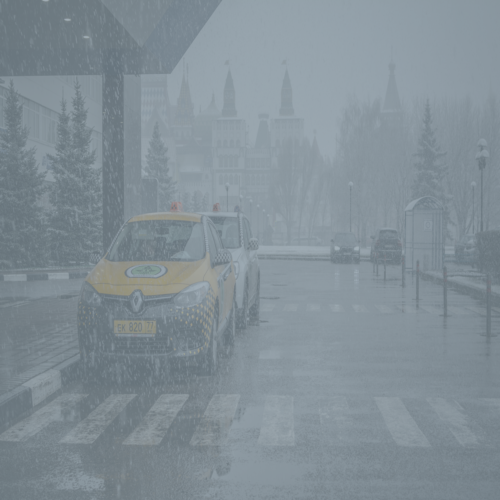

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


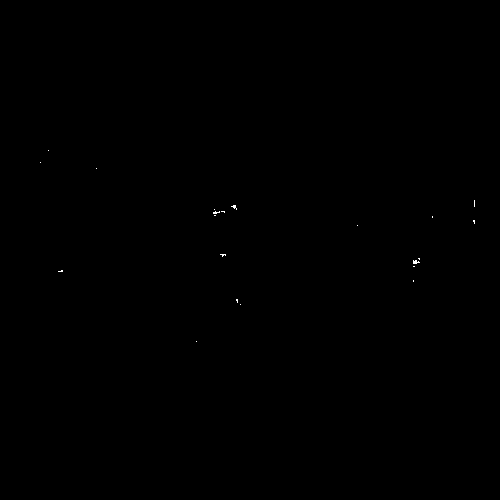

[[[0.32156864 0.2627451  0.20392157 ... 0.13725491 0.12941177 0.07843138]
  [0.3372549  0.22745098 0.16470589 ... 0.05882353 0.11764706 0.10196079]
  [0.3764706  0.12156863 0.05098039 ... 0.01176471 0.05882353 0.08235294]
  ...
  [0.15686275 0.12941177 0.10196079 ... 0.49411765 0.4862745  0.4862745 ]
  [0.14509805 0.11372549 0.09803922 ... 0.4862745  0.49019608 0.49803922]
  [0.15294118 0.13333334 0.10980392 ... 0.4745098  0.49411765 0.49019608]]

 [[0.7372549  0.85882354 0.91764706 ... 0.2509804  0.2627451  0.21960784]
  [0.72156864 0.8235294  0.89411765 ... 0.15686275 0.22745098 0.22352941]
  [0.6509804  0.5137255  0.49803922 ... 0.08627451 0.14509805 0.18431373]
  ...
  [0.12941177 0.11372549 0.09803922 ... 0.4627451  0.45490196 0.45490196]
  [0.12941177 0.10196079 0.09803922 ... 0.45882353 0.45490196 0.4627451 ]
  [0.13725491 0.1254902  0.10980392 ... 0.44313726 0.45882353 0.45490196]]

 [[0.7058824  0.87058824 0.9647059  ... 0.19215687 0.19215687 0.14117648]
  [0.7411765  0.839215

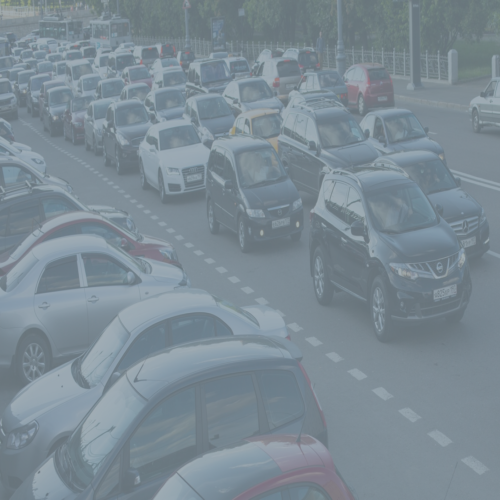

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


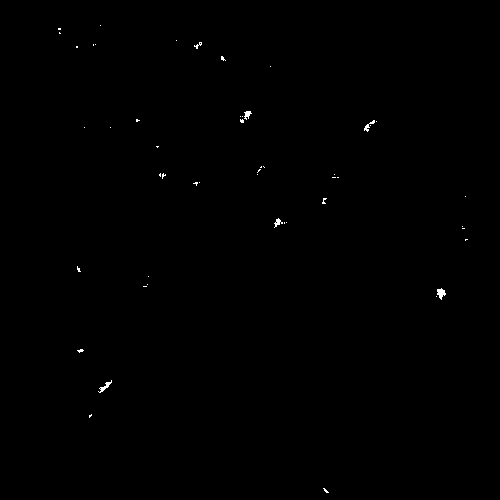

[[[0.58431375 0.59607846 0.6039216  ... 0.21960784 0.21568628 0.1254902 ]
  [0.6039216  0.60784316 0.61960787 ... 0.23921569 0.22745098 0.14901961]
  [0.60784316 0.6156863  0.627451   ... 0.25882354 0.22745098 0.14901961]
  ...
  [0.53333336 0.5294118  0.5254902  ... 0.32156864 0.3372549  0.3372549 ]
  [0.46666667 0.49411765 0.53333336 ... 0.32941177 0.34117648 0.34117648]
  [0.44313726 0.4745098  0.50980395 ... 0.3254902  0.3254902  0.33333334]]

 [[0.5921569  0.58431375 0.57254905 ... 0.20392157 0.20392157 0.11764706]
  [0.60784316 0.6        0.5882353  ... 0.22352941 0.21568628 0.14117648]
  [0.60784316 0.60784316 0.6039216  ... 0.24313726 0.21960784 0.14117648]
  ...
  [0.5019608  0.49803922 0.49411765 ... 0.24705882 0.2627451  0.2627451 ]
  [0.43529412 0.4627451  0.5019608  ... 0.2509804  0.2627451  0.2627451 ]
  [0.4117647  0.44313726 0.47843137 ... 0.24705882 0.24705882 0.25490198]]

 [[0.60784316 0.6039216  0.6        ... 0.20392157 0.20784314 0.11764706]
  [0.62352943 0.615686

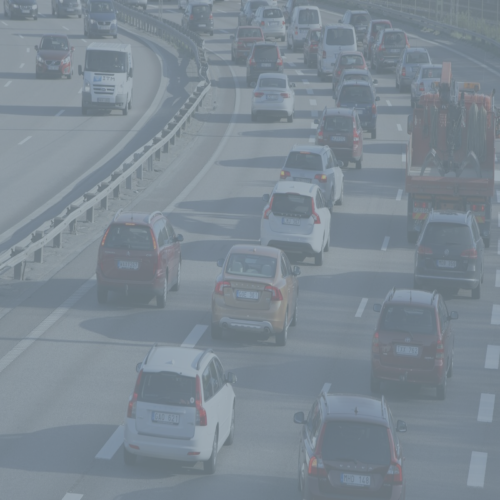

inputs torch.Size([1, 3, 500, 500])
(1, 1, 500, 500)
(1, 500, 500)


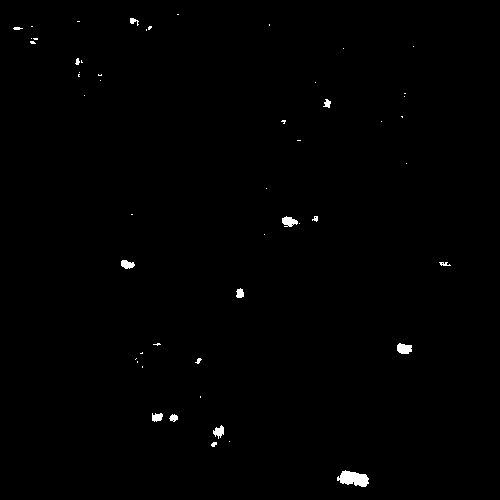

In [ ]:
test_img_paths = []
# for inputs , labels in dataloaders['train']:
#     print(type(inputs))
#     inputs = inputs.to(device)
#     labels = labels.to(device)
iter=0
test_val_dataloaders=[test_dataloader,val_dataloader]
flag_test_val=test_val_dataloaders[0]
mask_base64_array=[]
for inputs in flag_test_val:
    inputs = inputs.to(device)
    print(inputs[0].cpu().numpy())
    cv2_imshow(reverse_transform(inputs[0].cpu()))
    print('inputs',inputs.shape)
    outputs = model(inputs)
    outputs = F.sigmoid(outputs)
    outputs = outputs.data.cpu().numpy()
    for output in outputs:
      print(outputs.shape)
      print(outputs[0].shape)
      output = np.transpose(output, (1,2,0))
      # print(outputs.shape)
      # outputs=np.squeeze(outputs, axis = 0) 
      # print(outputs.shape)
      output = ((output - output.min()) * (1/(output.max() - output.min()) * 255)).astype('uint8')
      # outputs.save('my_f.png')
      # print(outputs)
      # Change channel-order and make 3 channels for matplot
      # input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]
      # cv2_imshow(input_images_rgb[0])
      ret,mask = cv2.threshold(output,150,255,cv2.THRESH_BINARY)
      # cv2_imshow(output)
      cv2_imshow(mask)
      cv2.imwrite('/content/current.png', mask)
      with open("/content/current.png", "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read())
        new_encoded_string=encoded_string.decode('utf-8')
        mask_base64_array.append(new_encoded_string)
    # print(outputs)
    # img = Image.fromarray(outputs, 'RGB')
    # img.save('my.png')
    # test_predictions.append(
    #     torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # test_predictions_arg.append(preds.argmax(dim=1).data.cpu().numpy())
    # test_img_paths.extend(paths)

In [ ]:
if flag_test_val==test_dataloader:
  test_submission = pd.DataFrame.from_dict({'base64 encoded PNG (mask)':mask_base64_array})
  test_submission.to_csv('test_submission.csv')

else:
  val_submission=pd.read_csv('/content/val_submission.csv')
  val_submission['base64 encoded PNG (mask)']=mask_base64_array
  val_submission.to_csv('val_submission.csv')
  print(val_submission.head())
# base64_submission_df = pd.DataFrame.from_dict({'base64 encoded PNG (mask)':mask_base64_array})
# print(base64_submission_df.head(n=20))


In [ ]:
# метрика
LABELS = ['c_kefir', 'ent_cloacae', 'klebsiella_pneumoniae', 'moraxella_catarrhalis',
          'staphylococcus_aureus', 'staphylococcus_epidermidis']
DATASET_PATH = '/content/val_json'
label_metrics = np.zeros((len(LABELS), len(LABELS)), int)
seg_metrics = []
df = pd.read_csv('val_submission.csv')
def set_metrics(filename):
      global label_metrics, seg_metrics, df

      with open(os.path.join(DATASET_PATH, filename), 'r') as f:
          layout = json.load(f)

      h, w = layout['imageHeight'], layout['imageWidth']
      true_mask = np.zeros((h, w), np.uint8)
      label = layout['shapes'][0]['label']

      for shape in layout['shapes']:
          polygon = np.array([point[::-1] for point in shape['points']])
          cv2.fillPoly(true_mask, [polygon[:, [1, 0]]], 255)

      ind = int((int(filename[:-len(FILE_FILTER[1])])-1)/val_part)
      new_label = df.at[ind, 'class']
      label_metrics[LABELS.index(new_label)][LABELS.index(label)] += 1

      with open('tmp_bacteria.png', 'wb') as fp:
          fp.write(base64.b64decode(df.at[ind, 'base64 encoded PNG (mask)'].encode()))
      mask = cv2.imread('tmp_bacteria.png', 0)
      seg_metrics += [np.count_nonzero(np.logical_and(true_mask, mask)) /
                      np.count_nonzero(np.logical_or(true_mask, mask))]
def calculate_metrics():
      # print(seg_metrics)
      mean_iou = np.mean(seg_metrics)
      precisions = dict.fromkeys(LABELS, 0.)
      for label in LABELS:
          i = LABELS.index(label)
          precisions[label] = label_metrics[i][i] / np.sum(label_metrics[i, :])
      mean_precision = np.mean(list(precisions.values()))

      score = mean_iou + np.sum(list(precisions.values()))

      print(f'mean_iou: {mean_iou}')
      for k, v in precisions.items():
          print(f'precision_{k}: {v}')
      print(f'mean_precision: {mean_precision}\nscore: {score}')


def main():
      files = os.listdir(DATASET_PATH)
      for file in sorted(filter(lambda x: x[-len(FILE_FILTER[1]):].lower() == FILE_FILTER[1], files)):
          set_metrics(file)
      calculate_metrics()


main()


FileNotFoundError: ignored

In [ ]:
kefir=seg_metrics[0:14]
cloacae=seg_metrics[14:31]
kleb=seg_metrics[31:34]
catarr=seg_metrics[34:42]
aur=seg_metrics[42:46]
epid=seg_metrics[46:51]

print('kefir',np.mean(kefir))
print('cloacae',np.mean(cloacae))
print('kleb',np.mean(kleb))
print('catarr',np.mean(catarr))
print('aur',np.mean(aur))
print('epid',np.mean(epid))